In [1]:
!pip install keras_vggface
!pip install keras_applications
!pip install mtcnn

In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, AUC
from tensorflow.math import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from tqdm import tqdm
from mtcnn.mtcnn import MTCNN
#from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.python.keras.engine
from tensorflow.keras import Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [3]:
TRAINING_DIR = r"C:\Users\pradi\OneDrive\Desktop\Final Year Project\dataset\real_vs_fake\real-vs-fake\train"
TEST_DIR = r"C:\Users\pradi\OneDrive\Desktop\Final Year Project\dataset\real_vs_fake\real-vs-fake\test"
VALIDATION_DIR = r"C:\Users\pradi\OneDrive\Desktop\Final Year Project\dataset\real_vs_fake\real-vs-fake\valid"

print(f'Total training images REAL: {len(os.listdir(os.path.join(TRAINING_DIR, "real")))}')
print(f'Total training images FAKE: {len(os.listdir(os.path.join(TRAINING_DIR, "fake")))}\n')

print(f'Total test images REAL: {len(os.listdir(os.path.join(TEST_DIR, "real")))}')
print(f'Total test images FAKE: {len(os.listdir(os.path.join(TEST_DIR, "fake")))}\n')

print(f'Total test images REAL: {len(os.listdir(os.path.join(VALIDATION_DIR, "real")))}')
print(f'Total test images FAKE: {len(os.listdir(os.path.join(VALIDATION_DIR, "fake")))}')


Total training images REAL: 50000
Total training images FAKE: 50000

Total test images REAL: 10000
Total test images FAKE: 10000

Total test images REAL: 10000
Total test images FAKE: 10000


In [5]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    #validation_split=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = 300
img_batch = 32

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='training',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    #subset='validation',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=img_batch,
    shuffle=False
)



Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


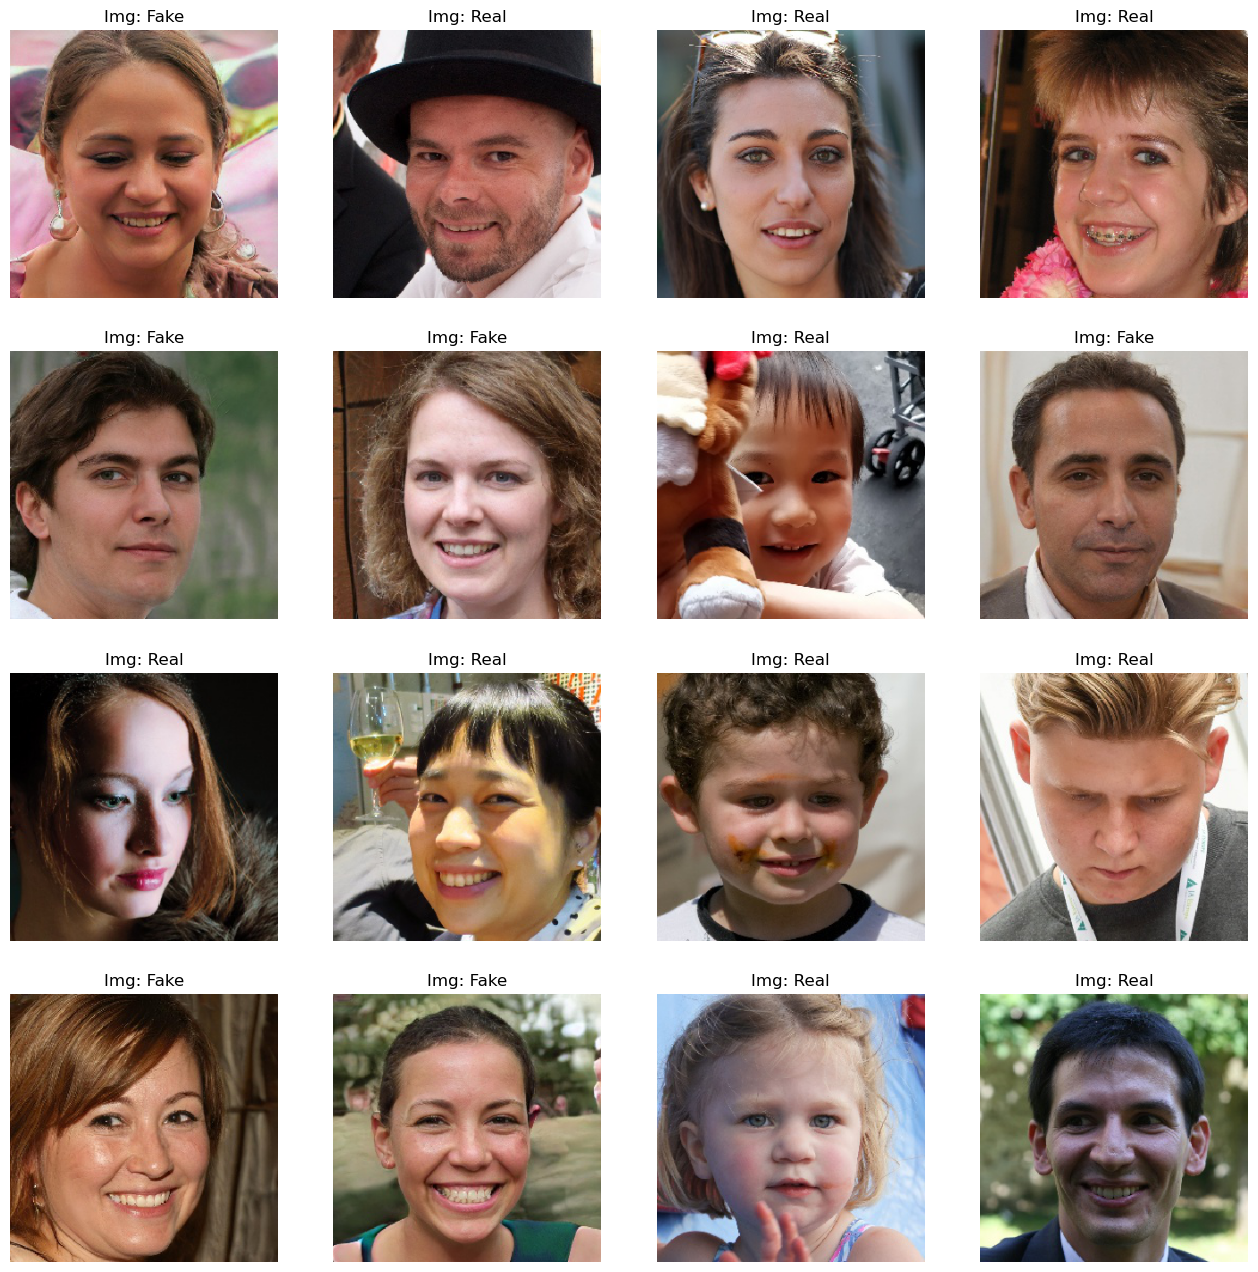

In [6]:
labels = {1.0: 'Real', 0.0: 'Fake'}

for images, images_labels in train_generator:
    plt.figure(figsize=(16, 16))
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break

In [11]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=25,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 64)      

25/25 [==============================] - 499s 21s/step - loss: 0.5387 - accuracy: 0.7262 - val_loss: 0.5266 - val_accuracy: 0.7398
Epoch 49/50
25/25 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7262
Epoch 49: val_loss did not improve from 0.52665
25/25 [==============================] - 525s 22s/step - loss: 0.5130 - accuracy: 0.7262 - val_loss: 0.5281 - val_accuracy: 0.7352
Epoch 50/50
25/25 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.7287
Epoch 50: val_loss did not improve from 0.52665
25/25 [==============================] - 490s 20s/step - loss: 0.5473 - accuracy: 0.7287 - val_loss: 0.5394 - val_accuracy: 0.7261


In [10]:
    model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=80,
    steps_per_epoch=40,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

40/40 [==============================] - 390s 10s/step - loss: 0.4862 - accuracy: 0.7555 - val_loss: 0.4827 - val_accuracy: 0.7693
Epoch 49/80
40/40 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.7805
Epoch 49: val_loss did not improve from 0.48273
40/40 [==============================] - 392s 10s/step - loss: 0.4720 - accuracy: 0.7805 - val_loss: 0.4946 - val_accuracy: 0.7604
Epoch 50/80
40/40 [==============================] - ETA: 0s - loss: 0.5100 - accuracy: 0.7602
Epoch 50: val_loss did not improve from 0.48273
40/40 [==============================] - 392s 10s/step - loss: 0.5100 - accuracy: 0.7602 - val_loss: 0.4898 - val_accuracy: 0.7640
Epoch 51/80
40/40 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.7664
Epoch 51: val_loss improved from 0.48273 to 0.47544, saving model to model.hdf5
40/40 [==============================] - 378s 10s/step - loss: 0.4794 - accuracy: 0.7664 - val_loss: 0.4754 - val_accuracy: 0.7745
Epoch 52/80
40/

40/40 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.8047
Epoch 77: val_loss did not improve from 0.42476
40/40 [==============================] - 388s 10s/step - loss: 0.4323 - accuracy: 0.8047 - val_loss: 0.4482 - val_accuracy: 0.7878
Epoch 78/80
40/40 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8070
Epoch 78: val_loss did not improve from 0.42476
40/40 [==============================] - 384s 10s/step - loss: 0.4159 - accuracy: 0.8070 - val_loss: 0.4252 - val_accuracy: 0.8066
Epoch 79/80
40/40 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.8102
Epoch 79: val_loss improved from 0.42476 to 0.42154, saving model to model.hdf5
40/40 [==============================] - 308s 8s/step - loss: 0.4145 - accuracy: 0.8102 - val_loss: 0.4215 - val_accuracy: 0.8068
Epoch 80/80
40/40 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8164
Epoch 80: val_loss did not improve from 0.42154
40/40 [=========

In [7]:
    model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=120,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

Epoch 20/100
120/120 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.7883
Epoch 20: val_loss improved from 0.46475 to 0.46291, saving model to model.hdf5
120/120 [==============================] - 1110s 9s/step - loss: 0.4557 - accuracy: 0.7883 - val_loss: 0.4629 - val_accuracy: 0.7815
Epoch 21/100
120/120 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.7753
Epoch 21: val_loss improved from 0.46291 to 0.46215, saving model to model.hdf5
120/120 [==============================] - 1122s 9s/step - loss: 0.4726 - accuracy: 0.7753 - val_loss: 0.4621 - val_accuracy: 0.7811
Epoch 22/100
120/120 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.7961
Epoch 22: val_loss did not improve from 0.46215
120/120 [==============================] - 1070s 9s/step - loss: 0.4469 - accuracy: 0.7961 - val_loss: 0.4647 - val_accuracy: 0.7773
Epoch 23/100
120/120 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.7878
E

Epoch 48/100
120/120 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8542
Epoch 48: val_loss did not improve from 0.35040
120/120 [==============================] - 1057s 9s/step - loss: 0.3404 - accuracy: 0.8542 - val_loss: 0.3662 - val_accuracy: 0.8384
Epoch 49/100
120/120 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.8521
Epoch 49: val_loss did not improve from 0.35040
120/120 [==============================] - 1566s 13s/step - loss: 0.3402 - accuracy: 0.8521 - val_loss: 0.5320 - val_accuracy: 0.7588
Epoch 50/100
120/120 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8484
Epoch 50: val_loss improved from 0.35040 to 0.34466, saving model to model.hdf5
120/120 [==============================] - 1370s 11s/step - loss: 0.3390 - accuracy: 0.8484 - val_loss: 0.3447 - val_accuracy: 0.8482
Epoch 51/100
120/120 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8523
Epoch 51: val_loss improved fro

120/120 [==============================] - 741s 6s/step - loss: 0.2750 - accuracy: 0.8844 - val_loss: 0.2870 - val_accuracy: 0.8804
Epoch 77/100
120/120 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8849
Epoch 77: val_loss did not improve from 0.28705
120/120 [==============================] - 736s 6s/step - loss: 0.2694 - accuracy: 0.8849 - val_loss: 0.2954 - val_accuracy: 0.8774
Epoch 78/100
120/120 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.8878
Epoch 78: val_loss improved from 0.28705 to 0.27242, saving model to model.hdf5
120/120 [==============================] - 760s 6s/step - loss: 0.2718 - accuracy: 0.8878 - val_loss: 0.2724 - val_accuracy: 0.8888
Epoch 79/100
120/120 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8763
Epoch 79: val_loss did not improve from 0.27242
120/120 [==============================] - 738s 6s/step - loss: 0.2922 - accuracy: 0.8763 - val_loss: 0.2760 - val_accuracy: 0.8867
Ep

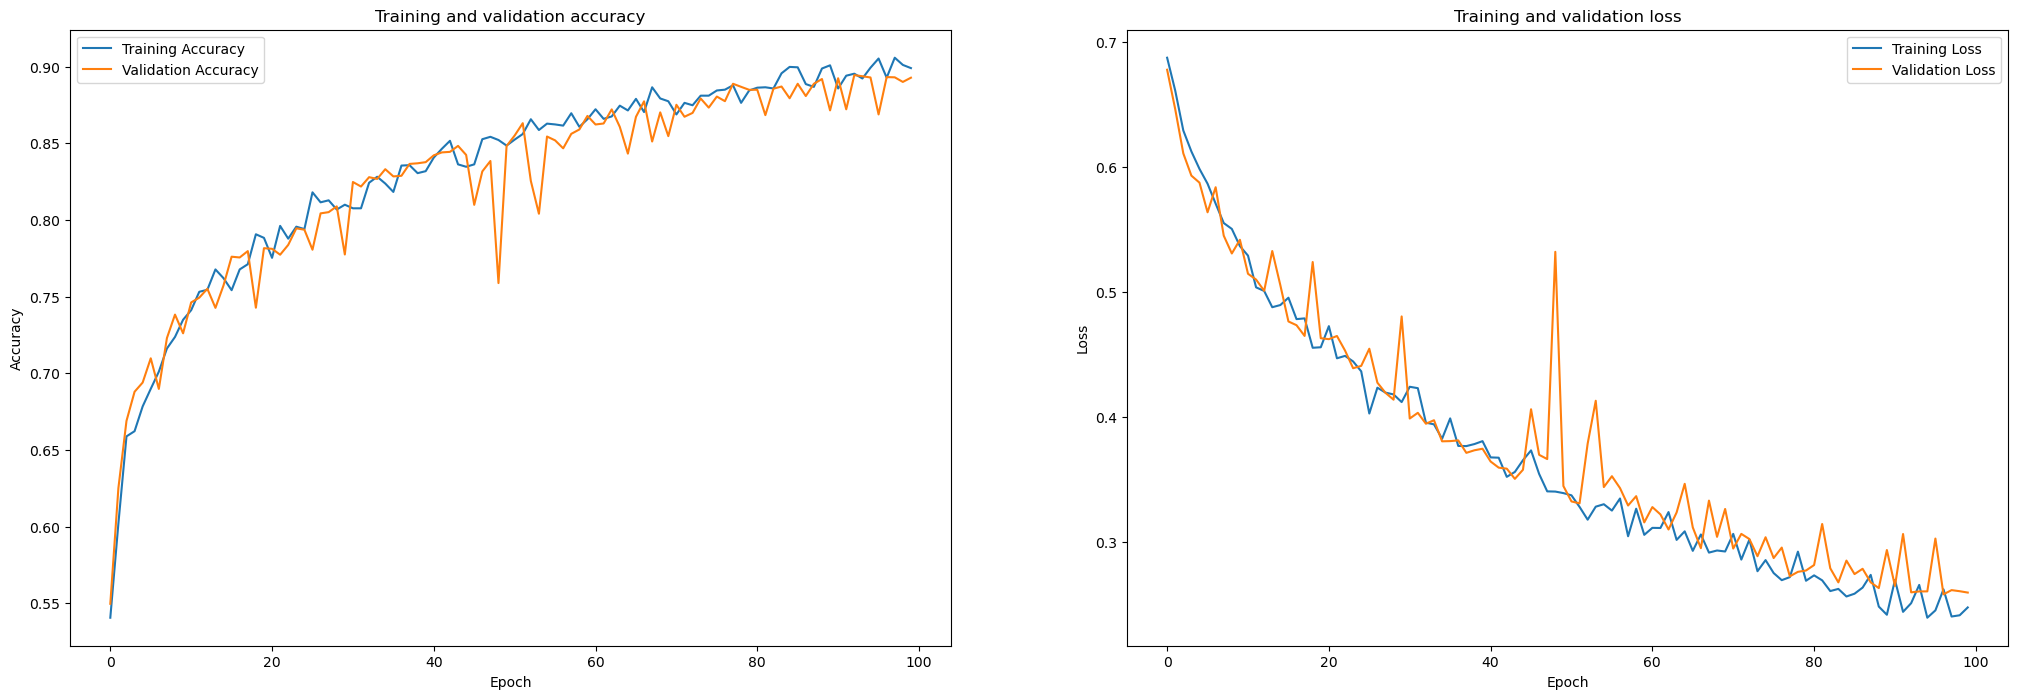

In [9]:
plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [12]:
metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
index_model_checkpoint = np.argmin(history.history['val_loss'])
[f'Best {metric}: {history.history[metric][index_model_checkpoint]:.2f}' for metric in metrics]

['Best accuracy: 0.89',
 'Best val_accuracy: 0.89',
 'Best loss: 0.26',
 'Best val_loss: 0.26']

In [10]:
def load_and_test_model(model_name, test_set, display_model_summary=False):
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model.hdf5')
    if display_model_summary:
        loaded_model.summary()
    test_loss, test_acc = loaded_model.evaluate(test_set)
    print(f'Test loss: {round(test_loss, 2)}, Test accuracy: {round(test_acc * 100, 2)}')

In [14]:
load_and_test_model('CNN_Base_8429', test_generator)

The model called does not exist. Testing for the last saved model.
625/625 [==============================] - 1620s 3s/step - loss: 0.2555 - accuracy: 0.8935
Test loss: 0.26, Test accuracy: 89.35


In [13]:
def calculate_model_performance_metrics(model_name, test_dataset, transfer_ml=False, model_version=0,
                                        show_plots=False):
    
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
        print(f'Calculating performance metrics for model {model_name}')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model.hdf5')

    if transfer_ml and model_version != 0:
        test_images, true_labels = test_dataset.as_numpy_iterator().next()
        test_images = utils.preprocess_input(test_images, version=model_version)
        predictions_sigmoid = loaded_model.predict(test_images, verbose=1)
    else:
        true_labels = test_dataset.labels
        predictions_sigmoid = loaded_model.predict(test_dataset, verbose=1)
    
    false_positives_negatives = []
    lower_bound_threshold = 0.2
    upper_bound_threshold = 0.7
    step = 0.001

    sigmoid_threshold = np.arange(lower_bound_threshold, upper_bound_threshold, step)

    for threshold in sigmoid_threshold:
        predictions_binary = tf.where(predictions_sigmoid > threshold, 1, 0)
        conf_matrix = confusion_matrix(true_labels, predictions_binary)
        false_positives_negatives.append(conf_matrix[0][1] + conf_matrix[1][0])

    min_threshold = sigmoid_threshold[np.argmin(false_positives_negatives)]
    print(f'Minimizer of false positives and false negatives: {min_threshold:.3f}')

    metrics_options = {
        'Precision': Precision,
        'Recall': Recall,
        'True Positives': TruePositives,
        'True Negatives': TrueNegatives,
        'False Positives': FalsePositives,
        'False Negatives': FalseNegatives
    }

    def disp_metrics(metric, threshold_value=min_threshold, verbose=False):
        metrics = metrics_options[metric](thresholds=threshold_value)
        metrics.update_state(true_labels, predictions_sigmoid)
        result = metrics.result().numpy()
        if verbose:
            print(f'{metric}: {result:.3f}')
        return result

    bin_acc = BinaryAccuracy(threshold=min_threshold)
    bin_acc.update_state(true_labels, predictions_sigmoid)
    print(f'Binary Accuracy: {bin_acc.result().numpy():.3f}')

    for metric in metrics_options.keys():
        disp_metrics(metric, verbose=True)

    rights = disp_metrics('True Positives') + disp_metrics('True Negatives')
    wrongs = disp_metrics('False Positives') + disp_metrics('False Negatives')
    print(f'Number of right guesses: {rights:.3f}')
    print(f'Number of wrong guesses: {wrongs:.3f}')

    auc = AUC()
    auc.update_state(true_labels, predictions_sigmoid)
    auc = auc.result().numpy()
    print(f'Area under curve ROC: {auc:.3f}')

    precision = disp_metrics('Precision')
    recall = disp_metrics('Recall')

    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f'F1-Score: {f1_score:.3f}')


    if show_plots:
        
        plt.figure(figsize=(18, 14))
    
        plt.subplot(2, 2, 1)
        plt.plot(sigmoid_threshold, false_positives_negatives, linewidth=3)
        plt.title('Sum of false positives and false negatives as a function of sigmoid threshold')
        plt.xlabel('Sigmoid threshold')
        plt.ylabel('False positives + False negatives')

        plt.subplot(2, 2, 2)
        cm = confusion_matrix(true_labels, tf.where(predictions_sigmoid > min_threshold, 1, 0))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f'Confusion matrix @{min_threshold:.3f}')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        plt.subplot(2, 2, 3)
        false_positive_rate, true_positive_rate, _ = roc_curve(true_labels, predictions_sigmoid)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=4)
        plt.title(f'Receiver Operating Characteristic curve for AUC: {auc:.3f}')
        plt.xlabel('False positive rate')
        plt.ylabel('True positives rate')
        plt.grid(True)

        plt.subplot(2, 2, 4)
        prec, rec, _ = precision_recall_curve(true_labels, predictions_sigmoid)
        plt.plot(rec, prec, linewidth=4)
        avg_precision_score = average_precision_score(true_labels, predictions_sigmoid)
        plt.title(f'Precision-Recall curve | Average precision score: {avg_precision_score:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
    
    return min_threshold

The model called does not exist. Testing for the last saved model.
625/625 [==============================] - 1211s 2s/step
Minimizer of false positives and false negatives: 0.459
Binary Accuracy: 0.894
Precision: 0.889
Recall: 0.899
True Positives: 8992.000
True Negatives: 8881.000
False Positives: 1119.000
False Negatives: 1008.000
Number of right guesses: 17873.000
Number of wrong guesses: 2127.000
Area under curve ROC: 0.961
F1-Score: 0.894


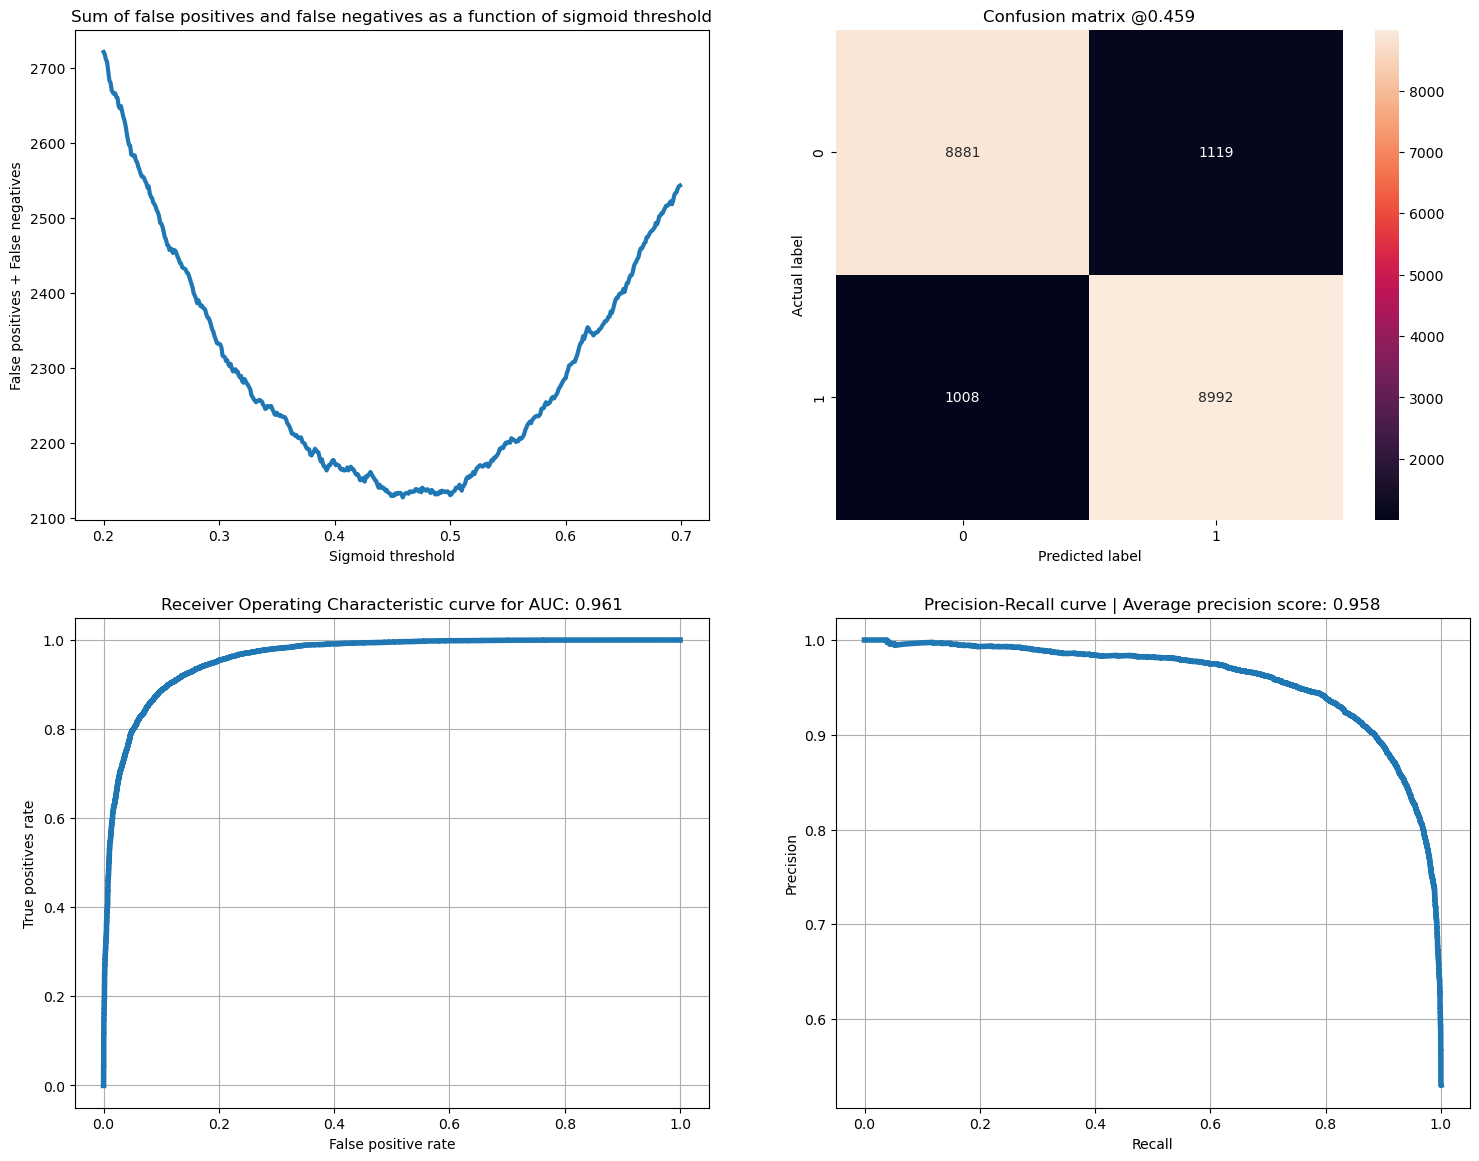

In [16]:
min_threshold = calculate_model_performance_metrics('CNN_Base_8429', test_generator, show_plots=True)

Found 20000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step


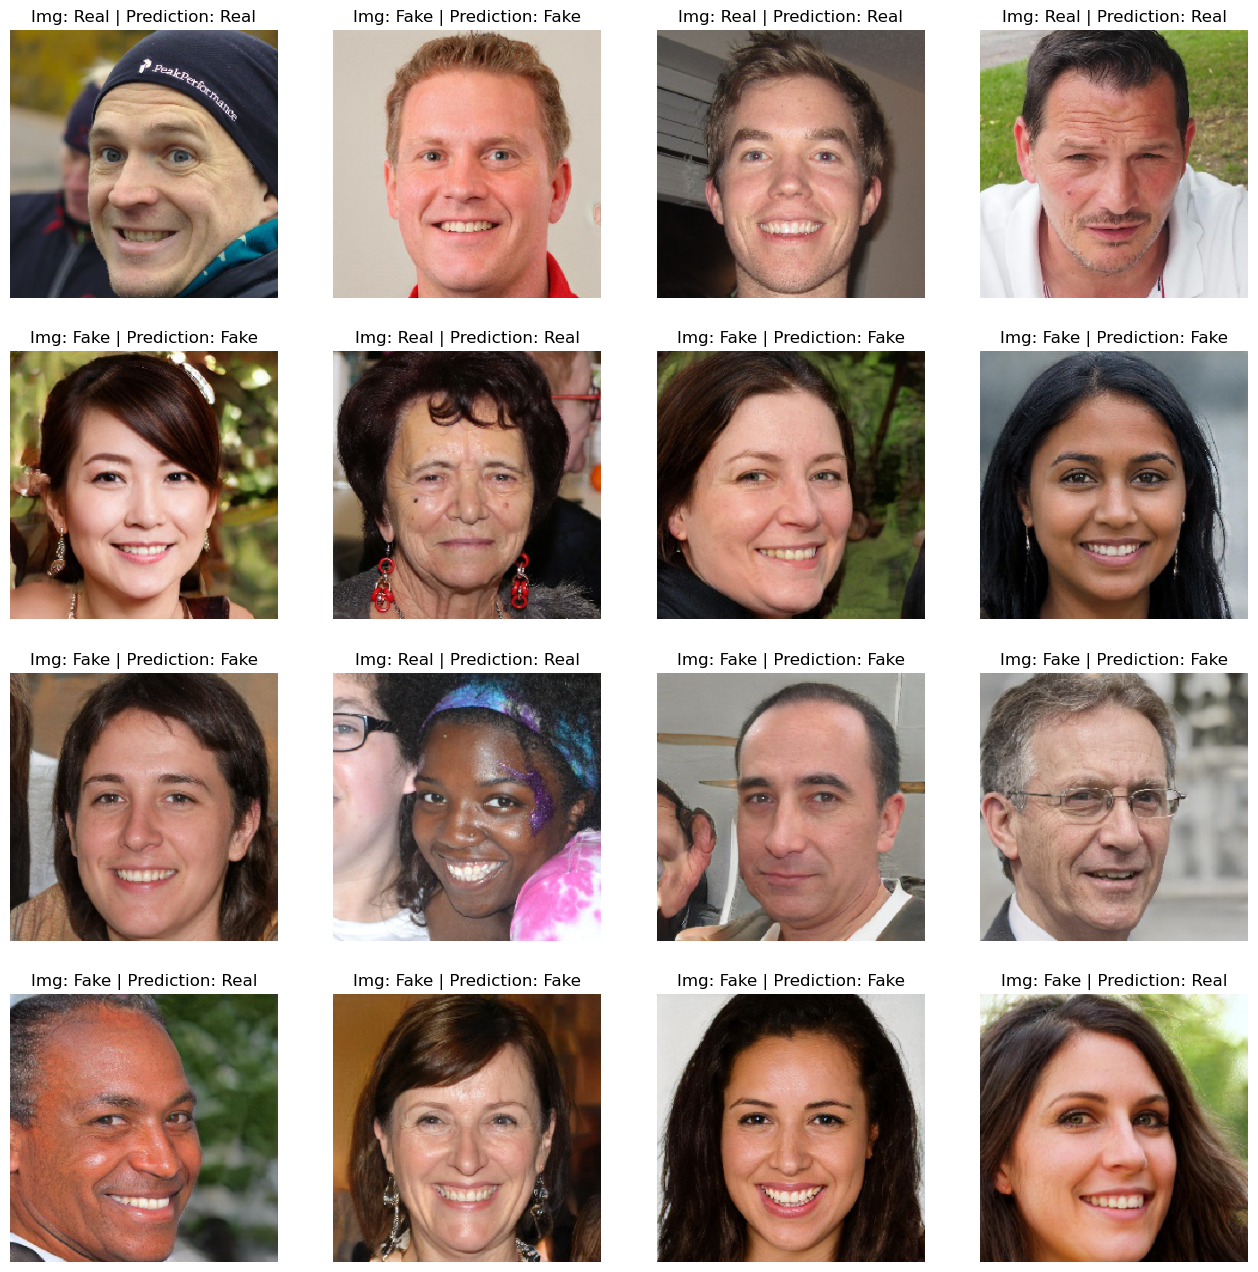

In [18]:
labels = {1.0: 'Real', 0.0: 'Fake'}

test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(img_size, img_size), class_mode='binary')
loaded_model = tf.keras.models.load_model('model.hdf5')

for images, images_labels in test_generator:
    plt.figure(figsize=(16, 16))
    predictions = tf.where(loaded_model.predict(images) > min_threshold, 1, 0)
    predictions = tf.reshape(predictions, [-1]).numpy()

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]} | Prediction: {labels[predictions[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break

In [4]:
vgg_img_size = 224
vgg_batch_size = 32

vgg_train_dataset = image_dataset_from_directory(
    TRAINING_DIR,
    batch_size=vgg_batch_size,
    image_size=(vgg_img_size, vgg_img_size),
    shuffle=True,
    seed=42,
)

vgg_validation_dataset = image_dataset_from_directory(
    VALIDATION_DIR,
    batch_size=vgg_batch_size,
    image_size=(vgg_img_size, vgg_img_size),
    shuffle=True,
    seed=42,
)

vgg_test_set = image_dataset_from_directory(
    TEST_DIR,
    batch_size=vgg_batch_size,
    image_size=(vgg_img_size, vgg_img_size),
    shuffle=False
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [5]:
vgg_model = VGGFace(include_top=False, model='vgg16', input_shape=(vgg_img_size, vgg_img_size, 3))

for layer in vgg_model.layers:
    layer.trainable = False

last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(512, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)
custom_vgg_model.summary()

custom_vgg_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = custom_vgg_model.fit(
    vgg_train_dataset,
    epochs=20,
    validation_data=vgg_validation_dataset,
    verbose=1,
    callbacks=callback
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [11]:
load_and_test_model('model', vgg_test_set)

625/625 [==============================] - 4389s 7s/step - loss: 0.1886 - accuracy: 0.9283
Test loss: 0.19, Test accuracy: 92.83
